In [2]:
import sys
read = sys.stdin.buffer.read
import time
from heapq import heappop, heappush
import random
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def initialize(n,xyr):
    res = []
    it = iter(xyr)
    for x,y,_ in zip(it,it,it):
        res.append([x,y,x+1,y+1])
    return res

In [4]:
def able_extend(x, r, ans):
    # O(4n)
    n = len(r)
    a,b,c,d = ans[x]
    ri = r[x]
    able_x = ri//(d-b) -(c-a)
    able_y = ri//(c-a) -(d-b)

    res = [min(a, able_x),
           min(b, able_y),
           min(10000-c, able_x),
           min(10000-d, able_y)] # up,left,down,right
    for i in range(n):
        if i == x:
            continue
        ai,bi,ci,di = ans[i]
        # up
        if b < di and bi < d and ci <= a:
            res[0] = min(res[0], a - ci)
        # down
        if b < di and bi < d and c <= ai:
            res[2] = min(res[2], ai - c)
        # left
        if a < ci and ai < c and di <= b:
            res[1] = min(res[1], b - di)
        # right
        if a < ci and ai < c and d <= bi:
            res[3] = min(res[3], bi - d)
    max_num = max(res)
    if max_num <= 0:
        return res,-1
    start = random.randint(-3,0)
    for i in range(start, start+4):
        if res[i] == max_num:
            return res,i%4

In [23]:
def eval_extend(x, r, ans, cyc, under):
    a,b,c,d = ans[x]
    ri = r[x]
    si = (c-a) * (d-b)
    point = 1 - (1 - min(ri,si)/max(ri,si))**2
    rem_point = 1 - point
    rem_area = max(0, ri-si)
        
    if rem_area == 0:
        return 0
    if cyc > 30:
        if cyc % 3 == 0:
            return 1 + random.random() * (cyc-under[x]+1)**4
        if cyc % 3 == 1:
            return (-1 * rem_point / rem_area)* (under[x]+1)**4
        else:
            return (1 / (-1 * rem_point / rem_area))* (under[x]+1)**4
    if cyc % 3 == 0:
        return 1 + random.random()
    if cyc % 3 == 1:
        return -1 * rem_point / rem_area
    else:
        return 1 / (-1 * rem_point / rem_area)

In [24]:
def calc_score(r,ans, under):
    n = len(r)
    res = 0
    for i in range(n):
        ri  = r[i]
        a,b,c,d = ans[i]
        si = (c-a) * (d-b)
        p = 1 - (1 - min(ri,si)/max(ri,si))**2
        res += p
        if p < 0.7:
            under[i] += 1
    return res, under

In [25]:
def visualize(r, res, xyr):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    
    base = patches.Rectangle(xy=(0,0), width=10000, height=10000, color='white')
    ax.add_patch(base)
    
    it = iter(xyr)
    for ri, abcd ,x,y,_ in zip(r, res, it,it,it):
        a,b,c,d = abcd
        xy = (a,b)
        wid = c-a
        hei = d-b
        si = wid*hei
        p = 1-(1-min(ri,si)/max(ri,si))**2
        
        
        box = patches.Rectangle(xy=xy, width=wid, height=hei,
                                color=plt.cm.bwr(p), alpha=0.7, label=int(p*100),
                                edgecolor='black')
        ax.add_patch(box)
        
        point = patches.Circle(xy = (x,y), radius=50)
        ax.add_patch(point)
        
        
        
    
    
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 10000)
    
    plt.show()

In [26]:
def main(*args): 
    start = time.time()
    TIME_LIMIT = 20
    random.seed(42)
    
    if len(args) == 0:
        n,*xyr = map(int,read().split())
    else:
        n = args[0]
        xyr = args[1]
    r = xyr[2::3]
    res = []
    res_p = 0
    cyc = 0
    under = [0] * n
    
    while time.time() - start < TIME_LIMIT:
        ans = initialize(n,xyr)
        ex_cnt = [0] * n
        eval_ex = []
        for i in range(n):
            eval_score = eval_extend(i, r, ans, cyc, under)
            if eval_score != 0:
                heappush(eval_ex, (eval_score, i))
        
        pr = []
        while time.time() - start < TIME_LIMIT and eval_ex:
            _,i = heappop(eval_ex)
            able_ex, idx = able_extend(i, r, ans)
            if idx == -1:
                continue
            
            if ex_cnt[i] < 20:
                idx = random.randint(0,3)
                ex_width = able_ex[idx]**0.5
                rand = random.random() * 0.5 + 1
                ex_width = math.ceil(ex_width * rand)
            elif ex_cnt[i] < 40:
                ex_width = able_ex[idx]**0.7
                rand = random.random() * 0.5 + 1
                ex_width = math.ceil(ex_width * rand)
            elif ex_cnt[i] < 60:
                rand = random.random() * 0.2 + 0.1 * min(8,(ex_cnt[i]-20)//4)
                ex_width = math.ceil(able_ex[idx] * rand)
            else:
                ex_width = math.ceil(able_ex[idx] * 0.1 + 0.9)

            ex_width = min(ex_width, able_ex[idx])
            # ex_width = max(ex_width, 1)
            if idx < 2:
                ans[i][idx] -= ex_width
            else:
                ans[i][idx] += ex_width
            eval_score =  eval_extend(i, r, ans, cyc, under)
            if eval_score == 0:
                continue
            ex_cnt[i] += 1
            heappush(eval_ex, (eval_score, i))

            pr.append((eval_score, i, idx, able_ex[idx], ex_width))
        
        point,under = calc_score(r,ans, under)
        cyc += 1
        # if cyc % 10 == 0:
        #     print(cyc)

        if res_p < point:
            res,ans = ans,res
            res_p = point
    
    # print(ex_cnt)
    print('\n'.join(map(lambda x: ' '.join(map(str,x)), res)))
    print(res_p)
    print(cyc)
    print(under)
    
    visualize(r, res, xyr)

In [27]:
n = 50
xyr = '''1909 360 6468907
5810 7091 4661329
5407 422 2010076
5767 3140 681477
6659 3234 920591
4206 1620 2487369
7853 9492 440133
7875 432 586159
9048 5059 1805425
7292 9070 509242
7633 2496 1558444
421 4835 1808752
7164 4109 35081
5356 2271 78438
5261 577 971398
3546 5225 1871979
4667 3386 28796
5596 7896 3310195
2518 9813 1739130
9002 3913 334620
8574 8947 1107057
3118 1773 669849
7140 4388 2098247
8544 8196 1742491
8577 4337 4435283
3155 9168 976005
7823 4404 945830
9451 110 569854
7031 1389 787729
1841 2337 942236
76 8364 710110
3543 3931 3840994
3927 8828 2920828
5671 3305 1526349
5542 4587 6285390
4030 7732 3962404
8575 8200 3662259
1139 3739 254000
50 7415 647735
934 4056 1800657
8801 7178 1218595
4499 6207 660560
3096 3375 2695827
5252 3281 1046149
2247 1446 7148429
3347 8501 7546190
5791 8600 3909497
8033 8992 3365971
2297 9254 23830
4312 6176 192104'''

xyr = list(map(int, xyr.split()))

0 0 3054 1361
4704 6272 7369 7170
3054 34 7715 465
5361 2580 6472 3193
6472 2753 8376 3235
4070 1423 7715 2105
7348 9424 8323 9875
7715 212 8150 1559
8999 4522 9407 8947
7112 7441 7343 9645
6472 2105 8376 2753
282 2234 723 6335
6834 4077 7207 4171
5123 2199 5470 2425
4210 479 6402 922
2756 4819 4981 5552
4606 3312 4777 3480
4315 7170 7112 7905
275 9326 3232 9914
8984 2841 9183 4522
8545 8947 9999 9708
2756 1641 4070 2150
6685 4171 7369 6272
8376 0 8545 10000
8545 0 8801 4338
273 8914 3237 9243
7498 3704 7990 5626
9211 55 9623 1438
3054 1239 7715 1408
1610 1780 1842 5841
0 7416 273 10000
2756 3852 4981 4819
3237 8606 5341 9994
5358 3235 8376 3703
5358 3703 6685 6272
273 7217 4315 7905
8545 4338 8801 8947
1124 2964 1281 4581
0 2918 144 7416
817 1361 1124 7217
8801 309 8954 8273
4331 5552 4704 7170
2812 2291 4538 3852
4981 2809 5358 5583
1842 1361 2756 7217
273 7905 7112 8600
5341 8600 7112 10000
7369 5628 8280 9322
2145 9243 2500 9310
4102 5784 4331 6622
47.47148270483132
133
[38, 31, 30

C:\Users\scare\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


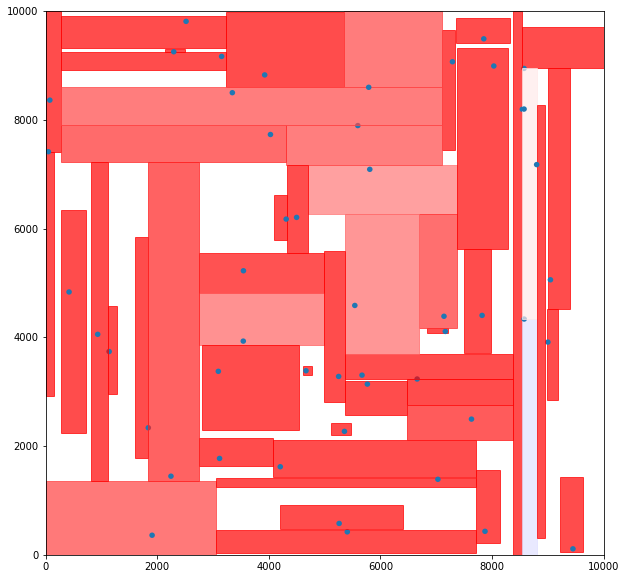

In [28]:
if __name__ == "__main__":
    main(n,xyr)
#     main()